#### Importing modules

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mode
import chiCa
from spks import *

%matplotlib widget

#### Loading sync data

In [2]:
from spks.sync import load_ni_sync_data,interp1d
sessionpath = Path('/home/data/GRB006/20240429_174359/')
sync_port = 0 # this is where the SMA of the probe is connected

(nionsets,nioffsets),(nisync,nimeta),(apsyncdata) = load_ni_sync_data(sessionpath=sessionpath)
aponsets = apsyncdata[0]['file0_sync_onsets'][6] # this should be the same for you, its where the sync is on the probe

corrected_onsets = {} # This is a dictionary with the digital events that were connected to the breakout box.
for k in nionsets.keys():
    corrected_onsets[k] = interp1d(nionsets[sync_port],aponsets,fill_value='extrapolate')(nionsets[k]).astype('uint64')

# if you need analog channels those are in "nisync"
nitime = interp1d(nionsets[sync_port],aponsets,fill_value='extrapolate')(np.arange(len(nisync)))

# everything is in samples, use this sampling rate
srate = apsyncdata[0]['sampling_rate']  

frame_rate = mode(1/(np.diff(corrected_onsets[1])/srate)) #corrected_onsets[1] are the frame samples, [2] are the trial start samples
trial_start_times = corrected_onsets[2][:-1]/srate

analog_signal = nisync[:, 0] # analog stim signal

In [54]:
behavior_data = chiCa.load_trialdata('/home/data/GRB006/20240429_174359/chipmunk/GRB006_20240429_174359_chipmunk_DemonstratorAudiTask.mat')

stim_onsets = []
for trial_index, timestamps in enumerate(chiCa.get_experienced_stimulus_events(behavior_data)): #behavior_data['stimulus_event_timestamps'])
    if True: #behavior_data.outcome_record[trial_index] != -1 and behavior_data.outcome_record[trial_index] != 2: 
        stim_timestamps = [trial_start_times[trial_index] + timestamp for timestamp in timestamps]
        stim_onsets.append(stim_timestamps)
    else: #discarding stimuli that occurred during early withdrawals and no choice trials
        stim_onsets.append(None)

first_stim_onsets = np.zeros(len(stim_onsets))
sk = np.zeros((len(stim_onsets)), dtype=object)
for trial, timestamps in enumerate(stim_onsets):
    if timestamps is None:
        first_stim_onsets[trial] = np.nan
        sk[trial] = np.nan
    else:
        first_stim_onsets[trial] = timestamps[0]
        sk[trial] = timestamps

sk_stacked = np.hstack(sk)
stim_kernel = sk_stacked[~np.isnan(sk_stacked)]

#check every thing has the correct size. length here should equal number of trials
assert len(first_stim_onsets) == len(stim_onsets) == len(sk)

/opt/conda/envs/spks-gabriel/lib/python3.12/site-packages/chiCa/chipmunk_analysis_tools.py:321: UserWarning: Found multisensory trials, assumed synchronous condition
  warnings.warn('Found multisensory trials, assumed synchronous condition')


bpod stimulus events: 4912
nidaq stimulus events: 4681


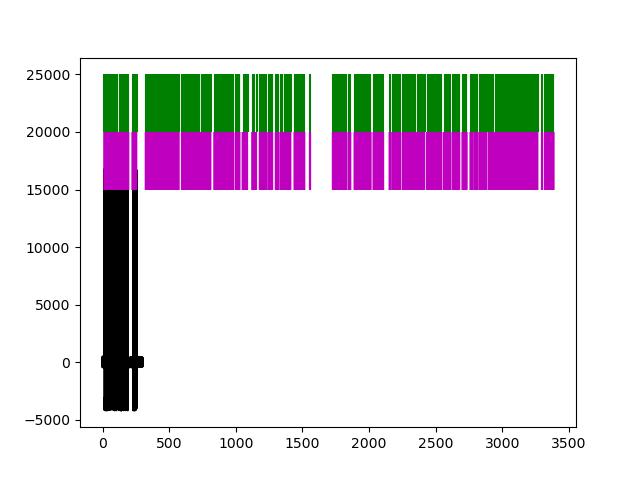

In [55]:
analog_signal = nisync[:, 0]
# threshold = 15000
# digital_signal = (analog_signal > threshold).astype(int)

t = nitime/srate
idx = t<300 #first # of seconds of the session
plt.figure()
plt.plot(t[idx],analog_signal[idx],'k')
# plt.plot(t[idx][valid_stim_indices],analog_signal[idx][valid_stim_indices],'ro')
# a,b = (t,analog_signal)
# plt.plot(a,15000*(b>2500),'b')
plt.vlines(corrected_onsets[2]/srate,20000,25000,'g') #trial starts

ii = np.where(np.diff(analog_signal>2500)==1)[0]
stim_events_nidaq = t[ii[np.diff(np.hstack([0,ii]))>0.04*srate]]
plt.vlines(stim_events_nidaq,15000,20000,'m') #stim events

print(f'bpod stimulus events: {len(np.hstack(stim_onsets))}\nnidaq stimulus events: {len(stim_events_nidaq)}') #stim events nidaq should be equal or less than the bpod ones since the bpod ones are the ones that are loaded, but not necessarily experienced by the mouse
#In summary, I should use the stim_events_nidaq as the stimulus onsets, and the corrected_onsets[2] as the trial onsets

Text(0.5, 1.0, 'Stimulus events identified')

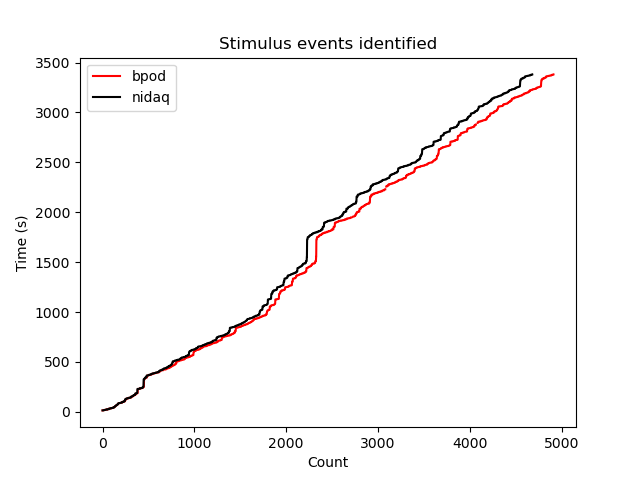

In [56]:
plt.figure()
plt.plot(np.hstack(stim_onsets), label = 'bpod', color = 'r')
plt.plot(stim_events_nidaq, label = 'nidaq', color = 'k')
plt.legend()
plt.xlabel('Count')
plt.ylabel('Time (s)')
plt.title('Stimulus events identified')

t = nitime/srate
idx = t<17 #first # of seconds of the session

analog_stim_diff = np.pad(np.diff(analog_signal).astype(float), (0, 1), 'constant', constant_values=np.nan)

threshold = 15000
stim_idx = np.where(analog_stim_diff[idx] > threshold)[0]
time_diffs = np.diff(stim_idx)
valid_stim_indices = stim_idx[np.insert(time_diffs >= 0.04*srate, 0, True)]

print(f'number of stimuli in the first trial: {len(valid_stim_indices)}')
print(f'first trial stim timestamp from nidaq analog_signal: {stim_idx[0]/srate}')
print(f'first trial stim timestamp from bpod behavior data: {stim_onsets[0][0]}\n')

ts = 0
print('nidaq/bpod stimulus timestamp ratio for each stimulus event in the first trial:')
while ts < len(valid_stim_indices):
    for nidaq, bpod in zip(iter([stim_idx[ts]/srate]), iter([stim_onsets[0][ts]])):
        print(nidaq / bpod)
    ts += 1

diff = np.diff(analog_signal[idx]).astype(float)
analog_stim_diff = np.pad(diff, (0,1), 'constant', constant_values=np.nan)

plt.close(5)
plt.figure(5)
plt.plot(t[idx], analog_stim_diff, 'k')
plt.show()

behavior_data = chiCa.load_trialdata('/home/data/GRB006/20240429_174359/chipmunk/GRB006_20240429_174359_chipmunk_DemonstratorAudiTask.mat')
stim_onsets = []
for trial_index, timestamps in enumerate(behavior_data.stimulus_event_timestamps):
    outcome = behavior_data.outcome_record[trial_index]
    if True:#outcome != -1:
        stim_timestamps = [trial_start_times[trial_index] + timestamp for timestamp in timestamps]
        stim_onsets.append(stim_timestamps)
    else:
        stim_onsets.append(None)

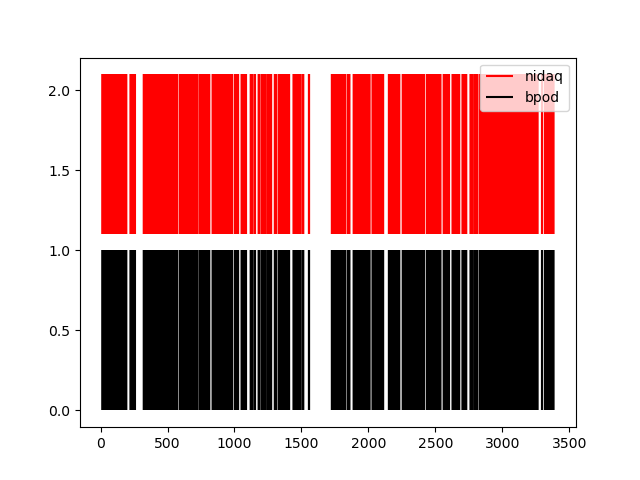

In [12]:
plt.figure()
plt.vlines(np.hstack(stim_events_nidaq),1.1,2.1,'r', label='nidaq')
plt.vlines(np.hstack(stim_onsets),0,1,'k', label='bpod')
plt.legend(loc='upper right')

##### Load clusters object for current session to obtain cluster IDs

Also filtering units using Melin et al. 2024 preprint criteria

In [ ]:
# binary_path = Path('/home/data/GRB006/20240429_174359/ephys_g0/ephys_g0_imec0/ephys_g0_t0.imec0.ap.bin')
# fast_binary_path = Path('/scratch/GRB/temp_bin/ephys_g0_t0.imec0.ap.bin')
kilosort_path = Path('/home/data/GRB006/20240429_174359/kilosort2.5/imec0/')

clu = Clusters(folder = kilosort_path, get_waveforms=False, get_metrics=True, load_template_features=True)

# ---------- this gets the row indices ---------- #
single_unit_idx = np.where((np.abs(clu.cluster_info.trough_amplitude - clu.cluster_info.peak_amplitude) > 50)
            & (clu.cluster_info.amplitude_cutoff < 0.1) 
            & (clu.cluster_info.isi_contamination < 0.1)
            & (clu.cluster_info.presence_ratio >= 0.6)
            & (clu.cluster_info.spike_duration > 0.1))[0]

# ---------- and this get the cluster_id values ---------- #
mask = ((np.abs(clu.cluster_info.trough_amplitude - clu.cluster_info.peak_amplitude) > 50)
            & (clu.cluster_info.amplitude_cutoff < 0.1) 
            & (clu.cluster_info.isi_contamination < 0.1)
            & (clu.cluster_info.presence_ratio >= 0.6)
            & (clu.cluster_info.spike_duration > 0.1))


single_unit_ids = clu.cluster_info[mask].cluster_id.values

#### Population activity heatmap across trials
Code taken from: https://github.com/jcouto/cshl_spks/blob/main/tutorials/tutorial_plot_psths.ipynb

In [ ]:
stim_kernel

In [ ]:
sc = np.load('/home/data/GRB006/20240429_174359/kilosort2.5/imec0/spike_clusters.npy') #KS clusters
ss = np.load('/home/data/GRB006/20240429_174359/kilosort2.5/imec0/spike_times.npy') #KS spikes (in samples)

st = ss/srate #conversion from spike samples to spike times

selection = np.isin(sc,single_unit_ids)

binsize = 0.01 # 10ms binsize
edges = np.arange(0,np.max(st[selection]),binsize)

pop_rate,_ = np.histogram(st[selection],edges)
pop_rate = pop_rate/binsize
pop_rate_time = edges[:-1]+np.diff(edges[:2])/2

psth = []
tpre = 0.1
tpost = 0.5

for onset in first_stim_onsets:
    if ~np.isnan(onset):
       psth.append(pop_rate[(pop_rate_time>= onset -tpre) & (pop_rate_time< onset +tpost)])
psth = np.stack(psth)
fig2 = plt.figure(figsize=(4,4))
plt.imshow(psth,aspect='auto',extent=[-tpre,tpost,0,len(psth)],cmap = 'RdBu_r',clim = [0,2500])
plt.vlines(x = 0, ymin = plt.ylim()[0], ymax = plt.ylim()[1], linestyles = 'dashed', color = 'k')
plt.colorbar(label='Population rate (Hz)')
plt.xlabel('time from first stim event')
plt.ylabel('Number of trials')
fig2.tight_layout()

In [ ]:
# sc = np.load('/home/data/GRB006/20240429_174359/kilosort2.5/imec0/spike_clusters.npy') #KS clusters
# ss = np.load('/home/data/GRB006/20240429_174359/kilosort2.5/imec0/spike_times.npy') #KS spikes (in samples)

# st = ss/srate #conversion from spike samples to spike times

# selection = np.isin(sc,single_unit_ids)

binsize = 0.0025 # 10ms binsize
edges = np.arange(0,np.max(st[selection]),binsize)

pop_rate,_ = np.histogram(st[selection],edges)
pop_rate = pop_rate/binsize
pop_rate_time = edges[:-1]+np.diff(edges[:2])/2

psth = []
tpre = 0.025
tpost = 0.025

for onset in stim_kernel:
    if ~np.isnan(onset):
       psth.append(pop_rate[(pop_rate_time>= onset -tpre) & (pop_rate_time< onset +tpost)])
psth = np.stack(psth)
kernel_fig = plt.figure(figsize=(4,4))
plt.imshow(psth,aspect='auto',extent=[-tpre,tpost,0,len(psth)],cmap = 'RdBu_r',clim = [0,2500])
plt.vlines(x = 0, ymin = plt.ylim()[0], ymax = plt.ylim()[1], linestyles = 'dashed', color = 'k')
plt.colorbar(label='Population rate (Hz)')
plt.xlabel('time from stim event')
plt.ylabel('Number of stim events')
kernel_fig.tight_layout()

In [ ]:
from useful_functions import separate_axes

def plot_population_psth(event_times, spike_times, pre=0.5, post=1, binw=0.01, use_kernel=False, kernel_width=2, ax=None):
    """
    Plots the Peri-Stimulus Time Histogram (PSTH) with SEM shading on a specific axis.
    
    Parameters:
    - event_times: array-like, times of the stimulus events.
    - spike_times: array-like, times of the spikes.
    - pre: float, time window before the stimulus event.
    - post: float, time window after the stimulus event.
    - binw: float, bin width for the histogram.
    - use_kernel: bool, whether to use Gaussian kernel smoothing.
    - kernel_width: float, width of the Gaussian kernel for smoothing.
    - ax: matplotlib axis object, axis to plot on.
    """
    if ax is None:
        ax = plt.gca()  # Get current axis if none is provided
    
    if use_kernel:
        psth_matrix, event_index = compute_firing_rate(
            event_times=event_times,
            spike_times=spike_times,
            pre_seconds=pre,
            post_seconds=post,
            binwidth_ms=int(binw * 1000),
            kernel=gaussian_function(kernel_width)
        )
    else:
        psth_matrix, event_index = compute_firing_rate(
            event_times=event_times,
            spike_times=spike_times,
            pre_seconds=pre,
            post_seconds=post,
            binwidth_ms=int(binw * 1000),
            kernel=None
        )
            
    trial_avg_psth = np.mean(psth_matrix, axis=0)
    trial_sem_psth = np.std(psth_matrix, axis=0) / np.sqrt(psth_matrix.shape[0])

    x_nums = np.arange(-pre, post, binw)
    if use_kernel:
        ax.plot(x_nums[:-1], trial_avg_psth, label='Average PSTH')
        ax.fill_between(x_nums[:-1], trial_avg_psth - trial_sem_psth, trial_avg_psth + trial_sem_psth, alpha=0.3, label='SEM')
    else:
        ax.plot(x_nums, trial_avg_psth, label='Average PSTH')
        ax.fill_between(x_nums, trial_avg_psth - trial_sem_psth, trial_avg_psth + trial_sem_psth, alpha=0.3, label='SEM')
    ax.vlines([0], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyles='dashed', color='gray')
    ax.set_xlabel('Time from first stimulus event (s)')
    ax.set_ylabel('Firing rate (Hz)')
    # ax.set_title(f'Trial avg PSTH with SEM; iunit: {iunit}')

    # separate_axes(ax)

binsize = 0.005
tpre = 0.025
tpost = 0.025
# pop_psth_fig, axs = plt.subplots(1,2, figsize=(12,12))
kernel_psth_fig, ax = plt.subplots(1,1, figsize=(12,12))
plot_population_psth(event_times=stim_kernel, spike_times=st, pre=tpre, post=tpost, binw=binsize, use_kernel=False, kernel_width=1, ax=ax)
# plot_population_psth(event_times=stim_kernel, spike_times=st, pre=tpre, post=tpost, binw=binsize, use_kernel=True, kernel_width=1, ax=axs[1])

In [ ]:
plt.close(pop_psth_fig)
binsize = 0.01
tpre = 0.5
tpost = 1
pop_psth_fig, axs = plt.subplots(1,2, figsize=(12,6))
# kernel_psth_fig, ax = plt.subplots(1,1, figsize=(12,12))
plot_population_psth(event_times=first_stim_onsets, spike_times=st, pre=tpre, post=tpost, binw=binsize, use_kernel=False, kernel_width=1, ax=axs[0])
plot_population_psth(event_times=first_stim_onsets, spike_times=st, pre=tpre, post=tpost, binw=binsize, use_kernel=True, kernel_width=1, ax=axs[1])

Playing around in the next cell with sorting the trials per total amounts of activity

In [ ]:
# # Assuming 'psth' is already defined and sorted_indices is obtained as before
# # Sum the responses for each trial
# trial_sums = np.sum(psth, axis=1)

# # Get the indices that would sort the trial sums in descending order
# sorted_indices = np.argsort(trial_sums)[::-1]

# # Apply the sorted indices to psth to sort it
# sorted_psth = psth[sorted_indices]

# # Create a mapping of sorted indices to original trial numbers
# trial_numbers = np.arange(len(psth)) + 1  # Assuming trial numbering starts from 1
# sorted_trial_numbers = trial_numbers[sorted_indices]

# tpre = 0
# tpost = 0.5

# # Plotting the sorted heatmap with trial identity maintained on the y-axis
# fig3 = plt.figure(figsize=(4, 4))
# ax = fig3.gca()
# heatmap = ax.imshow(sorted_psth, aspect='auto', extent=[-tpre, tpost, 0, len(sorted_psth)], cmap='RdBu_r', clim=[0, 2500])

# # Adjust the y-ticks to ensure they are spaced out appropriately
# # This might involve setting fewer y-ticks if there are many trials
# num_trials = len(sorted_trial_numbers)
# tick_spacing = max(1, num_trials // 10)  # Adjust the 10 to control tick density
# selected_ticks = np.arange(0, num_trials, tick_spacing)

# # Apply the selected ticks and their corresponding labels
# ax.set_yticks(selected_ticks)
# ax.set_yticklabels(sorted_trial_numbers[selected_ticks], fontsize=8)  # Adjust fontsize as needed

# plt.colorbar(heatmap, label='Population rate (Hz)')
# plt.xlabel('time from first stim event', fontsize=10)  # Adjust fontsize as needed
# plt.ylabel('Trial number', fontsize=10)  # Adjust fontsize as needed
# # fig3.tight_layout()

In [ ]:
#interesting units to plot
#excitation: 67, 28, 29, 32, 105, 136, 151, 154, 209, 216
#inhibition: 4, 82, 84, 67, 82, 99, 106, 162, 166, 167

In [ ]:
from useful_functions import individual_raster_viewer

clus = sc[selection]
# separate the spikes from each unit
spike_timestamps = [st[selection][clus == uclu] for uclu in np.unique(clus)]

trig_ts = []
for sp in spike_timestamps:
    trig_ts.append([])
    for o in first_stim_onsets:
        trig_ts[-1].append(sp[(sp>=(o-tpre)) & (sp<(o+tpost))] - o)
        
individual_raster_viewer(trig_ts)

In [ ]:
from spks.viz import plot_event_aligned_raster

fig3, ax = plt.subplots(1,1)
plot_event_aligned_raster(event_times=first_stim_onsets, spike_times=spike_timestamps[154], ax=ax)
fig3.tight_layout()

I prefer to get event aligned spks with the function below (get triggered spks)

from spks.event_aligned import *

tspks = get_triggered_spikes(spike_timestamps,first_stim_onsets,tpre = 1,tpost = 1)

fig4 = plt.figure()
plot_raster(spks=tspks[154])

In [ ]:
# from useful_functions import separate_axes

# pre = 0.5
# post = 1
# binw = 0.01

# psth_matrix, event_index = compute_firing_rate(event_times=first_stim_onsets, spike_times=timestamps[154], pre_seconds=pre, post_seconds=post, binwidth_ms=int(binw*1000), kernel=gaussian_function(2))
# trial_avg_psth = np.mean(psth_matrix, axis=0)
# trial_sem_psth = np.std(psth_matrix, axis=0) / np.sqrt(psth_matrix.shape[0])

# fig5 = plt.figure()
# x_nums = np.arange(-pre, post, binw)
# plt.plot(x_nums[:-1], trial_avg_psth)
# plt.fill_between(x_nums[:-1], trial_avg_psth - trial_sem_psth, trial_avg_psth + trial_sem_psth, alpha=0.3)
# plt.vlines([0], ymin = plt.ylim()[0], ymax = plt.ylim()[1], linestyles='dashed', color='gray')
# plt.ylabel('Firing rate (Hz)')
# plt.xlabel('Time from first stimulus event (s)')

# ax = plt.gca()
# separate_axes(ax)

In [ ]:
from useful_functions import plot_psth

fig5 = plt.figure()
plot_psth(iunit = 154, event_times = first_stim_onsets, spike_times = spike_timestamps, pre = 0.5, post = 1)
fig5.tight_layout()

In [ ]:
from useful_functions import individual_psth_viewer

fig6 = plt.figure()
individual_psth_viewer(event_times = first_stim_onsets, spike_times = spike_timestamps, pre = 0.5, post = 1)
fig6.tight_layout()

In [ ]:
first_stim_onsets